## データの読み込み

In [1]:
import dataset
import time
import numpy as np
from PIL import Image
from matplotlib import pylab as plt
%matplotlib inline

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
images, (type1, type2) = dataset.load_data()

801/801 done


In [3]:
type_dict = dataset.type_dict
type_labels = list(type_dict.keys())

## データの確認

In [4]:
# 各ラベルごとに画像を10枚格納
# img_list = []
# for for_1 in range(18):
#     choice_idx = np.random.choice(np.where(type1 == for_1)[0], 10)
#     img_list.append(images[choice_idx])

In [5]:
# データの可視化
# for for_1 in range(18):
#     fig, ax = plt.subplots(1, 10, figsize=(18, 8))
#     for for_2 in range(10):
#         ax[for_2].imshow(img_list[for_1][for_2].reshape(215, 215, 4))
#         ax[for_2].set_title(type_labels[for_1])
#         ax[for_2].axis('off')

## データの前処理

In [6]:
img_rows = images.shape[1]
img_cols = images.shape[2]
img_channels = images.shape[3]

In [7]:
images = images.astype('float32') / 255.0  # 正規化

In [8]:
nb_classes = len(type_labels)  # 正解のパターン数

In [9]:
from keras.utils import np_utils
# クラスベクトルをバイナリクラスの行列に変換する
type1_c = np_utils.to_categorical(type1, nb_classes)
type2_c = np_utils.to_categorical(type2, nb_classes)

Using TensorFlow backend.


## データの分割

In [10]:
boder = 649

img_train = images[:boder]
img_test = images[boder:]

types = type1_c + type2_c
types = np.where(types > 1., 1., types)

type_train = types[:boder]
type_test = types[boder:]

# 最後の可視化用
type1_test = type1[boder:]
type2_test = type2[boder:]

## モデルの構築

In [11]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization

In [12]:
input_layer = Input(shape=(img_rows, img_cols, img_channels))

x = Conv2D(32, kernel_size=3, padding='same')(input_layer)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.25)(x)

x = Conv2D(64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.25)(x)

x = Conv2D(128, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
x = Dense(nb_classes, activation="sigmoid")(x)

model = Model(inputs=input_layer, output=x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        1184      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
__________

In [14]:
# モデルの可視化
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 誤差関数

In [15]:
import keras.backend as K

In [16]:
# def binary_loss(y_true, y_pred):
#     bce = K.binary_crossentropy(y_true, y_pred)
#     return K.sum(bce, axis=-1)

## 評価関数

In [17]:
# def total_acc(y_true, y_pred):
#     pred = K.cast(K.greater_equal(y_pred, 0.5), "float")
#     flag = K.cast(K.equal(y_true, pred), "float")
#     return K.prod(flag, axis=-1)

# def binary_acc(y_true, y_pred):
#     pred = K.cast(K.greater_equal(y_pred, 0.5), "float")
#     flag = K.cast(K.equal(y_true, pred), "float")
#     return K.mean(flag, axis=-1)

In [18]:
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

## ジェネレーター

In [19]:
def generator(X, Y, batch_size):
    indices = np.arange(X.shape[0])
    while True:
        img_cahce, label_cache = [], []
        np.random.shuffle(indices)
        for i in indices:
            img_cahce.append(X[i])
            label_cache.append(Y[i])
            if len(img_cahce) == batch_size:
                X_batch = np.array(img_cahce)
                Y_batch = np.array(label_cache)
                img_cahce, label_cache = [], []
                yield X_batch, Y_batch

## 設定

In [20]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy','binary_accuracy'])

## 学習

In [21]:
from keras.callbacks import History

In [22]:
history = History()
batch_size = 32
model.fit_generator(generator(img_train, type_train, batch_size),
                   steps_per_epoch=len(img_train)//batch_size,
                   epochs=10,
                   verbose=1,
                   callbacks=[history],
                   validation_data=generator(img_test, type_test, batch_size),
                   validation_steps=len(img_test)//batch_size,)


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
20/20 [==============================] - 13s 653ms/step - loss: 0.7139 - acc: 0.8655 - binary_accuracy: 0.8655 - val_loss: 0.6587 - val_acc: 0.8663 - val_binary_accuracy: 0.8663
Epoch 2/10
20/20 [==============================] - 9s 472ms/step - loss: 0.4621 - acc: 0.8959 - binary_accuracy: 0.8959 - val_loss: 0.6385 - val_acc: 0.8676 - val_binary_accuracy: 0.8676
Epoch 3/10
20/20 [==============================] - 8s 413ms/step - loss: 0.3743 - acc: 0.9057 - binary_accuracy: 0.9057 - val_loss: 0.5732 - val_acc: 0.8828 - val_binary_accuracy: 0.8828
Epoch 4/10
20/20 [==============================] - 6s 322ms/step - loss: 0.3098 - acc: 0.9112 - binary_accuracy: 0.9112 - val_loss: 0.6575 - val_acc: 0.8398 - val_binary_accuracy: 0.8398
Epoch 5/10
20/20 [==============================] - 8s 376ms/step - loss: 0.2890 - acc: 0.9158 - binary_accuracy: 0.9158 - val_loss: 0.5445 - val_acc: 0.8576 - val_binary_accuracy: 0.8576
Epoch 6/10


## 評価結果

In [23]:
score = model.evaluate(x=img_test,
                       y=type_test,
                       verbose=0)
print(score)
# print('Test score:', score[0]) # 損失関数の値
# print('Test accuracy:', score[1]) # 精度
# print('Test binary_accuracy:', score[2]) # 精度

[0.5692424021269146, 0.8497806975716039, 0.8497806975716039]


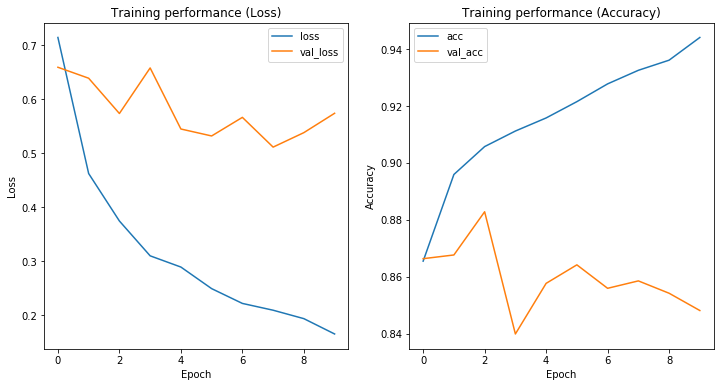

In [24]:
# 学習曲線
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['binary_accuracy'], label='acc')
ax[1].plot(history.epoch, history.history['val_binary_accuracy'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

## 可視化 

In [25]:
def test_generator(X, batch_size):
    indices = np.arange(X.shape[0])
    while True:
        img_cahce = []
        np.random.shuffle(indices)
        for i in indices:
            img_cahce.append(X[i])
            if len(img_cahce) == batch_size:
                X_batch = np.array(img_cahce)
                img_cahce = []
                yield X_batch

In [26]:
new_test = img_test

# 画像のラベルを推定する
batch_size = 1
pred = model.predict_generator(test_generator(new_test,batch_size),
                               steps=len(img_test)//batch_size,
                               verbose=1)

152/152 [==============================] - 2s 14ms/step


In [27]:
pred[0]

array([6.14473224e-03, 5.87549806e-03, 7.68740416e-01, 9.78003442e-02,
       1.29938126e-05, 8.20845366e-04, 3.19302082e-04, 7.69985557e-01,
       9.68664885e-04, 3.93930078e-03, 2.17688084e-03, 2.39332050e-01,
       2.05131531e-01, 1.68400705e-02, 1.86446726e-01, 9.14472640e-02,
       1.07719205e-01, 2.31053772e-08], dtype=float32)

Poison


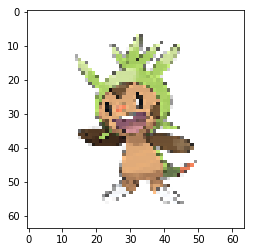

In [29]:
print(type_labels[np.argmax(pred[0])])
plt.imshow(new_test[0].reshape(64, 64, 4))

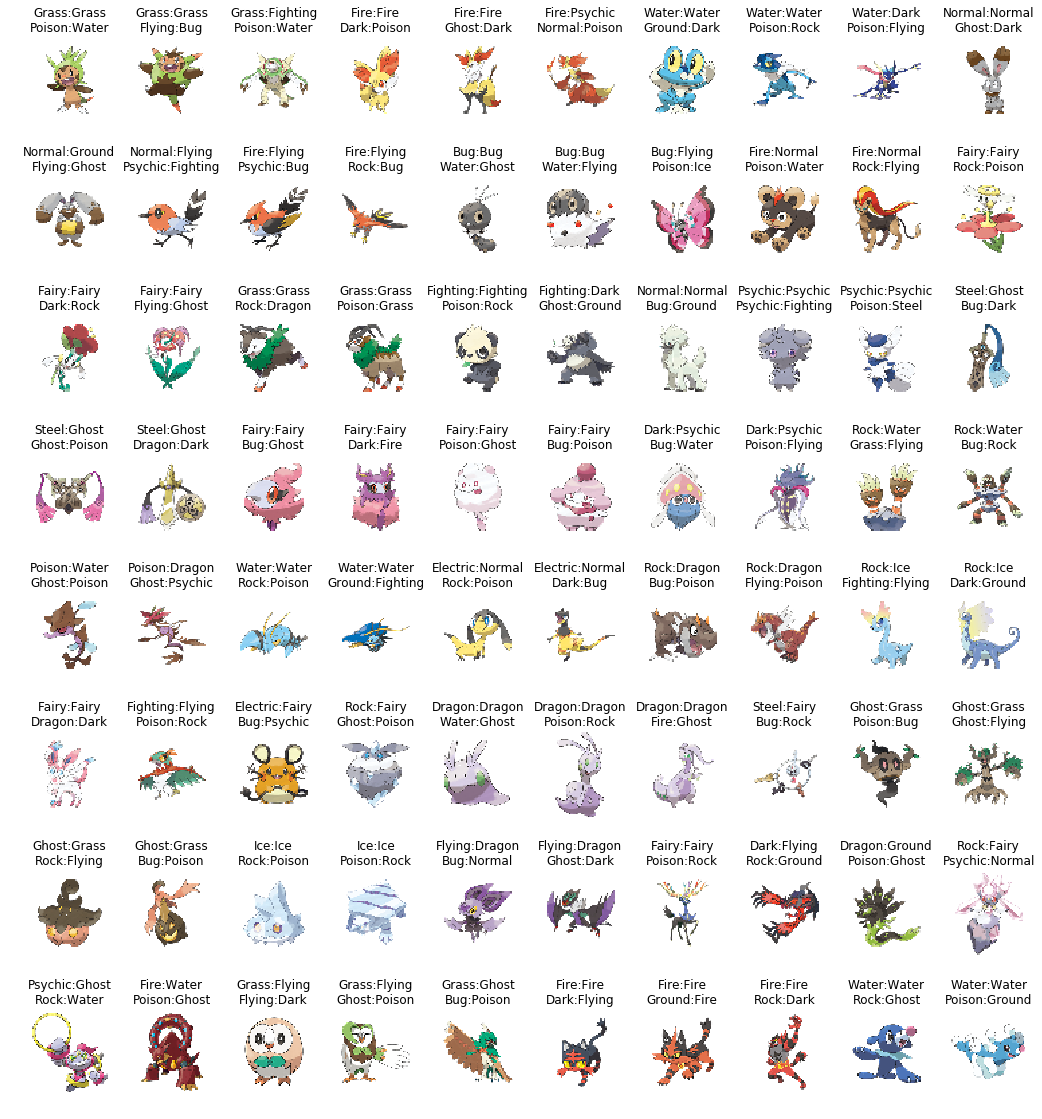

In [31]:
# データの可視化
# 上段は正しいラベル　下段は推測ラベル
fig, ax = plt.subplots(8, 10, figsize=(18, 20))
for for_1 in range(8):
    for for_2 in range(10):
        top_idx = np.argmax(pred[for_1*10+for_2])
        tmp = np.copy(pred[for_1*10+for_2])
        tmp[top_idx] = 0.
        second_idx = np.argmax(tmp)

        ax[for_1][for_2].imshow(new_test[for_1*10+for_2].reshape(64, 64, 4))
        ax[for_1][for_2].set_title(f'{type_labels[type1_test[for_1*10+for_2]]}:{type_labels[type2_test[for_1*10+for_2]]}'
                                   +'\n'
                                   +f'{type_labels[top_idx]}:{type_labels[second_idx]}')
        ax[for_1][for_2].axis('off')